In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time 
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

In [2]:
N = 500
M = 25000
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 2/3)
    b[i] = np.random.binomial(n[i], 2/3)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
#for i in range(10):
#    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

def OMPCL(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    
    for i in range(K):
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMPCL(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def calc_RE(pri_data, K, M):
    RE = 0
    pri_rank = rankdata(-pri_data)
    for i in range(K):
        for j in range(M):
            if pri_rank[j] == i + 1:
                RE += math.fabs(j-i)
                break
    RE /= K
    return RE

In [12]:
def calc_RE_exp(pri_data, K):
    RE = 0
    for i in range(K):
        RE += math.fabs(pri_data[i] - i)
    RE /= K
    return RE

In [13]:
def RankError(g, deltag, K, epsilon, s, m, phi, psi, A, k):
    RE = np.zeros(4)
    for j in range(10):
        #pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        #RE[0] += calc_RE(pri_comp_data, K, m)
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        RE[1] += calc_RE(pri_complap_data, K, m)
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        RE[2] += calc_RE(pri_lap_data, K, m)
        
        pri_exp_data = exp_mec(g, deltag, m, K, epsilon)
        RE[3] += calc_RE_exp(pri_exp_data, K)
    RE /= 10
        
    return RE

[[0.00000e+00 4.80000e+00 1.23002e+04 1.44981e+04]
 [0.00000e+00 5.30000e+00 1.33426e+04 1.27833e+04]
 [0.00000e+00 4.30000e+00 9.34180e+03 9.97250e+03]
 [0.00000e+00 3.40000e+00 0.00000e+00 1.56650e+03]
 [0.00000e+00 4.30000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 4.30000e+00 0.00000e+00 0.00000e+00]]
[[0.00000e+00 3.30000e+00 1.45191e+04 1.39654e+04]
 [0.00000e+00 5.20000e+00 1.56976e+04 1.03329e+04]
 [0.00000e+00 4.60000e+00 1.37261e+04 1.10506e+04]
 [0.00000e+00 4.50000e+00 1.44070e+03 3.00000e-01]
 [0.00000e+00 3.10000e+00 0.00000e+00 2.00000e-01]
 [0.00000e+00 3.80000e+00 0.00000e+00 0.00000e+00]]
[[0.00000e+00 4.80000e+00 1.48695e+04 8.08630e+03]
 [0.00000e+00 4.20000e+00 7.96170e+03 1.40725e+04]
 [0.00000e+00 4.40000e+00 9.50100e+03 1.25574e+04]
 [0.00000e+00 3.00000e+00 1.00000e-01 1.95250e+03]
 [0.00000e+00 3.20000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 4.30000e+00 0.00000e+00 0.00000e+00]]
[[0.00000e+00 3.40000e+00 1.06476e+04 1.64300e+04]
 [0.00000e+00 5.60000e+00 1.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.00000e+00 4.30000e+00 1.56056e+04 1.40444e+04]
 [0.00000e+00 4.70000e+00 1.17927e+04 1.97024e+04]
 [0.00000e+00 2.20000e+00 1.08217e+04 9.42160e+03]
 [0.00000e+00 4.10000e+00 0.00000e+00 1.88940e+03]
 [0.00000e+00 3.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 3.70000e+00 0.00000e+00 0.00000e+00]]


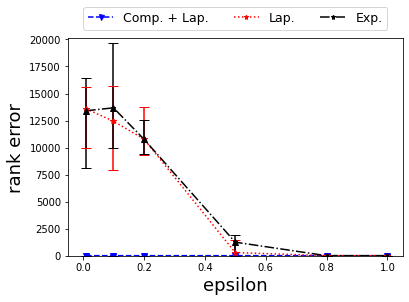

In [14]:
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
#ss = determineS(n,d,psi,eta)
#kk = int(np.floor(ss*math.log(n/ss)))
    
#phiphi = BernoulliMatrix(kk,n)
#AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=1.png")
fig.savefig("fig/RE_large_M=25000_K=1.eps")

[[0.00000000e+00 2.06046667e+03 1.24506667e+04 1.37315000e+04]
 [0.00000000e+00 5.74773333e+03 1.28683333e+04 1.63158000e+04]
 [0.00000000e+00 2.65373333e+03 1.35380333e+04 1.27893000e+04]
 [0.00000000e+00 1.96533333e+02 1.38786000e+04 1.33283000e+04]
 [0.00000000e+00 1.14993333e+03 1.10843333e+04 1.30363000e+04]
 [0.00000000e+00 4.36666667e+00 7.47196667e+03 1.03175000e+04]]
[[    0.          1276.93333333 10143.8        14676.6       ]
 [    0.           410.9        12151.13333333 12401.        ]
 [    0.          1048.43333333 10491.6        11564.56666667]
 [    0.          2181.66666667 13983.5        13166.23333333]
 [    0.           520.6        13050.23333333  8985.4       ]
 [    0.           663.13333333  6465.73333333  8068.86666667]]
[[0.00000000e+00 1.11860000e+03 1.16834667e+04 1.10649667e+04]
 [0.00000000e+00 4.06666667e+00 1.26601667e+04 1.09399333e+04]
 [0.00000000e+00 4.05000000e+02 1.18680333e+04 1.13599333e+04]
 [0.00000000e+00 1.02380000e+03 1.46314333e+04 1.2214

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.00000000e+00 8.95333333e+02 1.19047000e+04 1.18630000e+04]
 [0.00000000e+00 1.18453333e+03 1.17952333e+04 1.18282333e+04]
 [0.00000000e+00 2.58240000e+03 1.23009333e+04 1.25418667e+04]
 [0.00000000e+00 7.88700000e+02 1.22104667e+04 8.98570000e+03]
 [0.00000000e+00 3.40000000e+00 1.15846667e+04 9.41623333e+03]
 [0.00000000e+00 8.72000000e+01 9.50203333e+03 9.30606667e+03]]


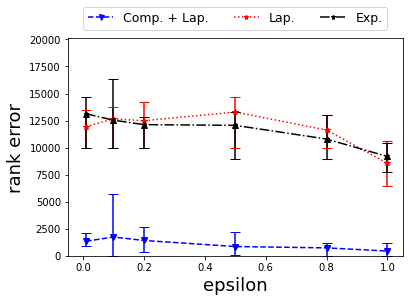

In [15]:
s = 10

K = 3

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=3.png")
fig.savefig("fig/RE_large_M=25000_K=3.eps")

[[    0.    2983.02 10222.86 13742.46]
 [    0.    4022.   11382.34 11956.06]
 [    0.    2527.7  13323.98 11599.06]
 [    0.    1789.18 13665.14 11996.2 ]
 [    0.    2181.86 10878.12 12990.66]
 [    0.    2317.12 11073.32 12168.24]]
[[    0.    3932.24 12620.82 12167.5 ]
 [    0.    1861.94 13603.32 12346.84]
 [    0.    3032.7  11122.36 11919.28]
 [    0.    1940.78 13935.96 10189.96]
 [    0.    1586.92  9681.96  9742.42]
 [    0.    2226.14 11975.7   9333.64]]
[[    0.    3864.1  12672.1  12996.54]
 [    0.    4692.22 12558.5  10867.76]
 [    0.    3383.48 12873.6  14224.52]
 [    0.    1191.2  12711.06 12997.64]
 [    0.    3528.26 12489.48 11644.14]
 [    0.    2811.98 11430.4  10539.28]]
[[    0.    2282.78 13282.66 13829.36]
 [    0.    2559.22 11605.3  12492.76]
 [    0.    5143.1  12160.28 13655.22]
 [    0.    3812.74 13738.28  9569.72]
 [    0.    2160.1  11690.4  12870.64]
 [    0.     847.   13824.94 10238.26]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[    0.    2210.58 13838.   10415.2 ]
 [    0.    2141.44 12570.86 12743.8 ]
 [    0.    1548.6  13201.44 11737.98]
 [    0.    2880.2  10917.36 13252.98]
 [    0.    2379.7  14356.58 11409.64]
 [    0.    2234.9   9860.16 10529.02]]


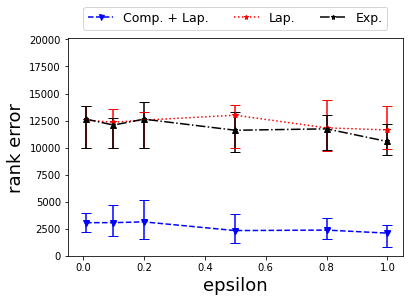

In [16]:
s = 10

K = 5

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=5.png")
fig.savefig("fig/RE_large_M=25000_K=5.eps")

[[    0.    7578.32 12582.86 11814.25]
 [    0.    8790.51 12147.55 12493.61]
 [    0.    8741.46 12032.73 12819.23]
 [    0.    7696.45 11433.4  12503.33]
 [    0.    7904.2  12027.02 12788.23]
 [    0.    6465.45 12595.95 13868.47]]
[[    0.    7450.66 13356.88 12339.96]
 [    0.    8256.53 12714.49 12084.91]
 [    0.    8113.78 13249.39 10504.43]
 [    0.    7872.32 13203.98 13200.46]
 [    0.    7087.69 13140.18 12001.42]
 [    0.    8184.33 11576.19 11067.12]]
[[    0.    7730.27 11281.65 11897.5 ]
 [    0.    7660.04 12961.24 13522.33]
 [    0.    6912.66 11493.19 12071.48]
 [    0.    6158.42 13331.37 11370.02]
 [    0.    6785.85 12158.44 12775.15]
 [    0.    6384.55 12169.57 11907.84]]
[[    0.    7714.45 12438.17 12054.82]
 [    0.    6657.98 13131.68 11920.75]
 [    0.    7397.46 12806.19 12200.8 ]
 [    0.    7509.31 12363.42 11793.19]
 [    0.    6388.73 11286.87 12076.74]
 [    0.    8541.32 11800.83 11564.23]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[    0.    8163.36 12326.2  12250.94]
 [    0.    7045.19 11214.54 12502.82]
 [    0.    7271.13 12293.49 11200.65]
 [    0.    8092.64 12509.3  12706.65]
 [    0.    6707.12 12072.71 12096.92]
 [    0.    7631.56 12103.03 13337.35]]


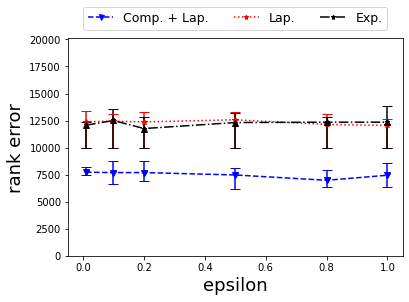

In [17]:
s = 10

K = 10

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=10.png")
fig.savefig("fig/RE_large_M=25000_K=10.eps")